# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

**Задача:** построить модель, которая умеет определять рыночную стоимость автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
качество предсказания;
время обучения модели;
время предсказания модели.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import OrdinalEncoder

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


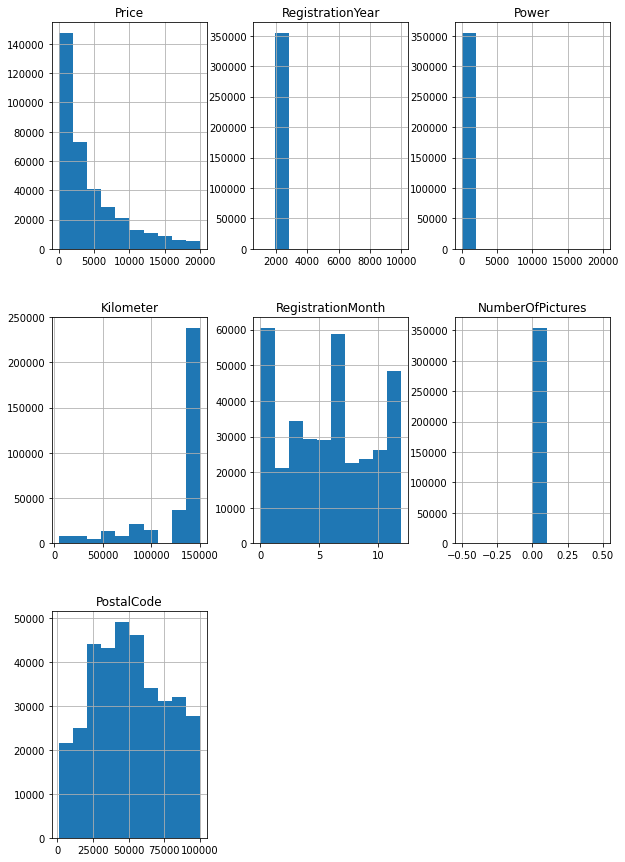

In [3]:
df.hist(figsize=(10, 15))
plt.show()

Гистограммы для столбцов `RegistrationYear`, `Power`, `NumberOfPictures` выглядят странно. Проверим эти столбцы на наличие аномалий.
Также, стоит проверить столбец `Price` на наличие аномалий (слишком низкая или нулевая цена). 

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- `Price`. В столбце есть нулевые значения. Вряд ли получитася действительно найти авто, которое будет стоить менее 25 тыс.руб.(~ 300 евро). Заменим все значения <300 медианой.


- `RegistrationYear`. Минимальное значение - 1000, Максмальное - 9999. Это, очевидно, аномальные отношения, и , так как их немного - можно удалить. 


- `Power`. В данных минимальная мощность - 0, масимальная - 20000. Ни того ни другого не может быть. Существующие сейчас минимальная и максимальная мощности для автомобилей - 50-60 и 2000 л.с. соответственно. Таких мощных автомобилей единицы. 75% всех значений меньше 143 л.с. Удалим значения > 300 л.с. Значений, меньших 50 л.с. много Заменим эти значения на медианные.


- `NumberOfPictures`. И минимальное и максимальное значение 0 - столбец не содержит значений и не будет влиять на обучение модели. Его можно удалить.

Так же на обучение не повлияют столбцы `RegistrationMonth`, `DateCrawled`, `DateCreated`и `LastSeen` и их так же можно удалить.

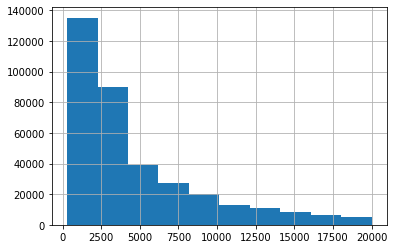

count    354369.000000
mean       4587.469313
std        4394.875810
min         300.000000
25%        1400.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [5]:
df.loc[(df['Price']<300), 'Price'] = df['Price'].median()
df['Price'].hist()
plt.show()
df['Price'].describe()

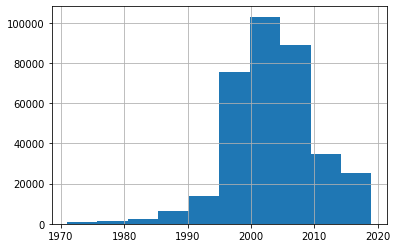

count    352593.000000
mean       2003.281398
std           6.890340
min        1971.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

In [6]:
df['RegistrationYear'] = df.loc[(df['RegistrationYear']<2023)&(df['RegistrationYear']>1970), 'RegistrationYear']
df['RegistrationYear'].hist()
plt.show()
df['RegistrationYear'].describe()

(0.0, 300.0)

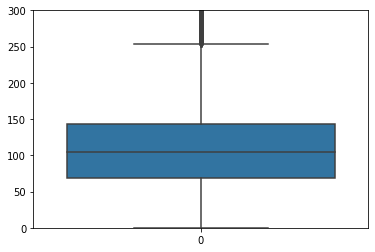

In [7]:
sns.boxplot(data=df['Power'])
plt.ylim(0,300)

Выбросы начинаются примерно с уровня 250 л.с. Удалим выбросы больше300 л.с.

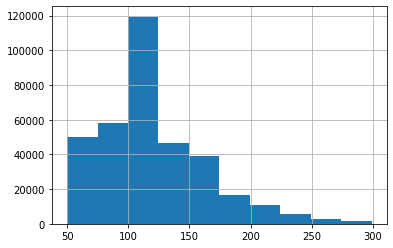

count    350650.000000
mean        116.982301
std          44.929772
min          50.000000
25%          88.000000
50%         102.000000
75%         140.000000
max         299.000000
Name: Power, dtype: float64

In [8]:
df['Power'] = df.loc[df['Power']<300, 'Power']
df.loc[df['Power']<50, 'Power'] = df['Power'].median()
df['Power'].hist()
plt.show()
df['Power'].describe()

### Исследование пропусков и дубликатов

In [9]:
df.duplicated().sum()

4

Дубликатов мало - их удаление не повлияет на исследование

In [10]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [11]:
# Удаление ненужных столбцов
df = df.drop(['NumberOfPictures','DateCrawled','DateCreated','RegistrationMonth','LastSeen', 'PostalCode'], axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480.0,NaN,1993.0,manual,102.0,golf,150000,petrol,volkswagen,NaN
1,18300.0,coupe,2011.0,manual,190.0,NaN,125000,gasoline,audi,yes
2,9800.0,suv,2004.0,auto,163.0,grand,125000,gasoline,jeep,NaN
3,1500.0,small,2001.0,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600.0,small,2008.0,manual,69.0,fabia,90000,gasoline,skoda,no


In [12]:
df.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear     1776
Gearbox             19833
Power                3719
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` Пропусков много. Исследуем каждый из этих столбцов. 
- В столбцах, которые уже содержат наименование 'other', заменим пропуски на 'other'. 

- В столбце `Gearbox`заменим на самый популярный тип коробки предач - 'auto'
- В столбце `Repaired` заменим пропуски на наиболее часто встречающийся вариант ('yes' или 'no')

Пропуски в столбцах `RegistrationYear`, `Power` можно удалить или заменить медианными значениями.

In [13]:
df['RegistrationYear'] = df['RegistrationYear'].fillna(df['RegistrationYear'].median())
df['Power'] = df['Power'].fillna(df['Power'].median())

In [14]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df['VehicleType'].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

In [15]:
df['Gearbox'] = df['Gearbox'].fillna('auto')
df['Gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [16]:
df['Model'] = df['Model'].fillna('other')
df['Model'].unique()

array(['golf', 'other', 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

In [17]:
df['FuelType'] = df['FuelType'].fillna('other')
df['FuelType'].unique()

array(['petrol', 'gasoline', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [18]:
print(df.loc[df['Repaired']=='yes','Repaired'].count()/df.loc[df['Repaired']=='no','Repaired'].count())

0.14587025303651915


Машин не бывших в ремонте встречается значительно меньше.

In [19]:
df['Repaired'] = df['Repaired'].fillna('no')
df['Repaired'].unique()

array(['no', 'yes'], dtype=object)

In [20]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Таким образом, в ходе обработки данных: 
- Удалены аномальные значения в столбцах `RegistrationYear`, `Power`.
- В столбце `Price` аномальные значения заменены медианой.
- Удалены столбцы  `RegistrationMonth`, `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen`, `PostalCode`
- Удалены дубликаты
- В столбцах `RegistrationYear`, `Power` пропуски заменены медианным значением.
- В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` пропуски заменены на 'other' или на наиболее часто встречающуюся характеристику.

## Обучение моделей

Будем исследовать модели **Случайный лес**,  **CatBoost** и **LightGBM**

### Разделение на выборки

Так как таблица содержит категориальные признаки, среди которых много параметров(`VehicleType`, `Model`, `FuelType`, `Brand`,), будем использовать порядковое кодирование (OE). 

In [21]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480.0,other,1993.0,manual,102.0,golf,150000,petrol,volkswagen,no
1,18300.0,coupe,2011.0,manual,190.0,other,125000,gasoline,audi,yes
2,9800.0,suv,2004.0,auto,163.0,grand,125000,gasoline,jeep,no
3,1500.0,small,2001.0,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600.0,small,2008.0,manual,69.0,fabia,90000,gasoline,skoda,no


In [22]:
features = df.drop(['Price'],axis=1)
target = df['Price'].reset_index(drop=True)

# разделение на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=12345, test_size=.25)

print(features_train.shape)
print(features_test.shape)

(265773, 9)
(88592, 9)


In [23]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
283908,bus,2001.0,manual,122.0,other,150000,petrol,mitsubishi,no
131329,wagon,2004.0,auto,204.0,a4,150000,gasoline,audi,no
345689,coupe,2007.0,manual,200.0,other,150000,gasoline,alfa_romeo,no
152481,small,1998.0,manual,68.0,corsa,150000,petrol,opel,no
93707,suv,1990.0,manual,69.0,other,70000,petrol,suzuki,no


In [24]:
encoder = OrdinalEncoder(handle_unknown='ignore')

features_train_oe = pd.DataFrame(encoder.fit_transform(features_train), columns=features_train.columns)
features_train_oe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,0.0,30.0,1.0,72.0,166.0,12.0,6.0,22.0,0.0
1,7.0,33.0,0.0,154.0,29.0,12.0,2.0,1.0,0.0
2,2.0,36.0,1.0,150.0,166.0,12.0,2.0,0.0,0.0
3,5.0,27.0,1.0,18.0,83.0,12.0,6.0,24.0,0.0
4,6.0,19.0,1.0,19.0,166.0,7.0,6.0,35.0,0.0


In [25]:
# стандартизация
columns_ss = ['RegistrationYear', 'Power', 'Kilometer']
all_col = list(features_train.columns)

scaler = StandardScaler()
scaler_oe = StandardScaler()

scaler.fit(features_train[columns_ss])
scaler_oe.fit(features_train_oe[all_col])

features_train[columns_ss] = scaler.transform(features_train[columns_ss])
features_train_oe[all_col] = scaler_oe.transform(features_train_oe[all_col])
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
283908,bus,-0.331928,manual,0.115713,other,0.576128,petrol,mitsubishi,no
131329,wagon,0.104829,auto,1.949140,a4,0.576128,gasoline,audi,no
345689,coupe,0.541586,manual,1.859705,other,0.576128,gasoline,alfa_romeo,no
152481,small,-0.768685,manual,-1.091666,corsa,0.576128,petrol,opel,no
93707,suv,-1.933371,manual,-1.069307,other,-1.532449,petrol,suzuki,no


In [26]:
features_train_oe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,-2.046178,-0.331928,0.566272,0.116099,0.768687,0.499596,0.707181,0.082962,-0.33625
1,1.409963,0.104829,-1.765937,1.951349,-1.192217,0.499596,-1.559799,-1.495413,-0.33625
2,-1.058709,0.541586,0.566272,1.861825,0.768687,0.499596,-1.559799,-1.570574,-0.33625
3,0.422494,-0.768685,0.566272,-1.092480,-0.419306,0.499596,0.707181,0.233283,-0.33625
4,0.916229,-1.933371,0.566272,-1.070099,0.768687,-1.332892,0.707181,1.060051,-0.33625


### Обучение моделей

In [27]:
def RMSE(target,predict):
    return mean_squared_error(target, predict) ** 0.5

#### Случайный лес

In [28]:
%%time

RMSE_score = make_scorer(RMSE, greater_is_better=False)
model_forest = RandomForestRegressor(random_state=12345)
params_forest = {'n_estimators':range(100,101,1),
                 'max_depth':[10, 15, 20]}

grid_forest = GridSearchCV(model_forest, params_forest, cv=5, scoring=RMSE_score, n_jobs=-1)
grid_forest.fit(features_train_oe, target_train)

print('Лучшие параметры модели:', grid_forest.best_params_)

Лучшие параметры модели: {'max_depth': 20, 'n_estimators': 100}
CPU times: user 11min 32s, sys: 7.2 s, total: 11min 39s
Wall time: 11min 42s


In [28]:
%%time
model_forest = RandomForestRegressor(random_state=12345, max_depth=15, n_estimators=100)
model_forest.fit(features_train_oe, target_train)

CPU times: user 55.1 s, sys: 106 ms, total: 55.2 s
Wall time: 55.4 s


RandomForestRegressor(max_depth=15, random_state=12345)

In [29]:
%%time
prediction_forest = model_forest.predict(features_train_oe)

CPU times: user 4.15 s, sys: 12 µs, total: 4.15 s
Wall time: 4.16 s


In [30]:
print('RMSE модели случайный лес:', RMSE(target_train, prediction_forest))

RMSE модели случайный лес: 1485.5316656874957


Время обучения: 55.4 s

Время предсказания: 4.16 s

#### CatBoost

**С кодированием**

In [32]:
%%time

model_cat = CatBoostRegressor(iterations=100, verbose=False, random_state=12345)
params_cat = {'learning_rate':[0.1, 0.15], 
                    'depth':[10, 15, 20]} 

grid_cat = GridSearchCV(model_cat, params_cat, cv=5, scoring = RMSE_score, n_jobs=-1)
grid_cat.fit(features_train_oe, target_train)

print('Лучшие параметры модели CatBoost:', grid_cat.best_params_)

Лучшие параметры модели CatBoost: {'depth': 15, 'learning_rate': 0.15}
CPU times: user 8min 32s, sys: 3min 47s, total: 12min 20s
Wall time: 12min 42s


In [31]:
%%time
model_cat_oe =  CatBoostRegressor(iterations=100, verbose=False, random_state=12345, learning_rate=0.15, depth=15)
model_cat_oe.fit(features_train_oe, target_train)

CPU times: user 40.3 s, sys: 22.2 s, total: 1min 2s
Wall time: 1min 3s


In [32]:
%%time
prediction_cat_oe = model_cat_oe.predict(features_train_oe)

CPU times: user 289 ms, sys: 294 µs, total: 289 ms
Wall time: 288 ms


In [33]:
print('RMSE модели CatBoost с кодированием:', RMSE(target_train, prediction_cat_oe))

RMSE модели CatBoost с кодированием: 1600.4873994628529


Время обучения: 63 s

Время предсказания: 288 ms

**Без кодирования**

In [34]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [35]:
%%time
model_cat = CatBoostRegressor(iterations=100, verbose=False,  cat_features = cat_features, 
                               random_state=12345, learning_rate=0.15, depth=15)
model_cat.fit(features_train, target_train)

CPU times: user 53.7 s, sys: 10.7 s, total: 1min 4s
Wall time: 1min 5s


In [36]:
%%time
prediction_cat = model_cat.predict(features_train)

CPU times: user 551 ms, sys: 7.11 ms, total: 559 ms
Wall time: 560 ms


In [37]:
print('RMSE модели CatBoost без кодирования:', RMSE(target_train, prediction_cat))

RMSE модели CatBoost без кодирования: 1565.646940520935


Время обучения: 65 s

Время предсказания: 560 ms

#### LightGBM

**С кодированием**

In [40]:
%%time

model_lgbm_oe = LGBMRegressor(random_state=12345)
params_lgbm_oe = {'n_estimators':[100, 150], 
                  'num_leaves':[10, 15]} 
grid_lgbm_oe = GridSearchCV(model_lgbm_oe, params_lgbm_oe, cv=5, scoring = RMSE_score, n_jobs=-1)
grid_lgbm_oe.fit (features_train_oe, target_train)

print('Лучшие параметры модели LightGBM:', grid_lgbm_oe.best_params_)

Лучшие параметры модели CatBoost: {'n_estimators': 150, 'num_leaves': 15}
CPU times: user 57min 47s, sys: 36 s, total: 58min 23s
Wall time: 58min 39s


In [38]:
%%time

model_lgbm_oe = LGBMRegressor(random_state=12345, n_estimators=150, num_leaves=15) 
model_lgbm_oe.fit(features_train_oe, target_train)

CPU times: user 1min 17s, sys: 743 ms, total: 1min 17s
Wall time: 1min 18s


LGBMRegressor(n_estimators=150, num_leaves=15, random_state=12345)

In [39]:
%%time
prediction_lgbm_oe = model_lgbm_oe.predict(features_train_oe)

CPU times: user 2.26 s, sys: 0 ns, total: 2.26 s
Wall time: 2.23 s


In [40]:
print('RMSE модели LightGBM с кодированием:', RMSE(target_train, prediction_lgbm_oe))

RMSE модели LightGBM с кодированием: 1919.3947085501209


Время обучения: 1 min 18 s

Время предсказания: 2.23 s

**Без кодирования**

In [41]:
features_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand','Repaired']]=\
features_train[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand','Repaired']].astype('category')

In [42]:
%%time

model_lgbm = LGBMRegressor(random_state=12345, n_estimators=150, num_leaves=15) 
model_lgbm.fit(features_train, target_train, categorical_feature=cat_features, verbose=False)

CPU times: user 1min 46s, sys: 938 ms, total: 1min 47s
Wall time: 1min 47s


LGBMRegressor(n_estimators=150, num_leaves=15, random_state=12345)

In [43]:
%%time
prediction_lgbm = model_lgbm.predict(features_train)

CPU times: user 3.03 s, sys: 0 ns, total: 3.03 s
Wall time: 2.98 s


In [44]:
print('RMSE модели LightGBM с кодированием:', RMSE(target_train, prediction_lgbm))

RMSE модели LightGBM с кодированием: 1796.1235647816134


Время обучения: 1 min 47 s

Время предсказания: 2.98 s

#### Константная модель

In [45]:
model_mean = DummyRegressor(strategy="mean")
model_mean.fit(features_train, target_train)
prediction_mean = model_mean.predict(features_train)
print('RMSE модели константной модели:', RMSE(target_train, prediction_mean))

RMSE модели константной модели: 4397.2071190257975


## Анализ моделей

In [46]:
models = {'Модель':['RandomForest', 'CatBoost OE', 'CatBoost Category','LGBMRegressor OE','LGBMRegressor Category','Mean'],
         'Время обучения':['55.4 s', '63 s', '65 s', '78 s', '107 s', '-'],
         'Время предсказания':['4.16 s', '0.29 s', '0.56 s', '2.23 s', '2.98 s', '-'],
         'RMSE':['1486', '1600', '1566', '1919', '1796', '4397']}

display(pd.DataFrame.from_dict(models))


,Модель,Время обучения,Время предсказания,RMSE
0,RandomForest,55.4 s,4.16 s,1486
1,CatBoost OE,63 s,0.29 s,1600
2,CatBoost Category,65 s,0.56 s,1566
3,LGBMRegressor OE,78 s,2.23 s,1919
4,LGBMRegressor Category,107 s,2.98 s,1796
5,Mean,-,-,4397


Все модели показали результат RMSE лучше, чем константная модель. Наилучший (минимальный) результат у модели RandomForest. Она же самая быстрая по времени обучения, однако модель CatBoost Category намного быстрее по времени предсказания, и почти не уступает по качеству предсказания. 
Таким образом, наилучшими моделями можно назвать RandomForest и CatBoost Category. Проверим эти модели на тестовой выборке.

In [47]:
# кодирование и стандартизация тестовой выборки
features_test_oe = features_test
features_test_oe = pd.DataFrame(encoder.transform(features_test_oe), columns=features_test_oe.columns)

features_test_oe[all_col] = scaler_oe.transform(features_test_oe[all_col])
features_test[columns_ss] = scaler.transform(features_test[columns_ss])

features_test_oe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,1.409963,0.104829,0.566272,0.071337,-1.363975,0.499596,0.707181,-0.142520,-0.33625
1,-0.071240,-2.224542,0.566272,-0.331523,-1.378288,-2.432386,0.707181,1.210373,-0.33625
2,0.422494,-0.186342,0.566272,-1.182005,0.110281,0.499596,0.707181,0.684248,-0.33625
3,-0.564975,1.851858,-1.765937,-1.405816,0.768687,-0.233399,0.140436,0.834569,-0.33625
4,0.422494,-1.205442,-1.765937,-1.271529,0.053028,0.499596,0.707181,1.285533,-0.33625


In [48]:
prediction_forest = model_forest.predict(features_test_oe)
print('RMSE модели RandomForest на тестовой выборке:', RMSE(target_test, prediction_forest))

RMSE модели RandomForest на тестовой выборке: 1785.683320222774


In [49]:
prediction_cat = model_cat.predict(features_test)
print('RMSE модели CatBoost Category на тестовой выборке:', RMSE(target_test, prediction_cat))

RMSE модели CatBoost Category на тестовой выборке: 1741.068850059678


Обе модели показали хороший результат на тестовой выборке. RMSE модели CatBoost Category чуть выше, чем у модели RandomForest.
Учитывая так же примерно одинаковое время обучения и высокую скорость обучения модели CatBoost Category относительно модели RandomForest, модель CatBoost Category является более предпочтительной для решения поставленной задачи.

## Вывод

В ходе работы над проектом была проведена предобработка данных:
- Удалены аномальные значения в столбцах `RegistrationYear`, `Power`.
- В столбце `Price` аномальные значения заменены медианой.
- Удалены столбцы  `RegistrationMonth`, `DateCrawled`, `DateCreated`, `NumberOfPictures`, `LastSeen`, `PostalCode`
- Удалены дубликаты
- В столбцах `RegistrationYear`, `Power` пропуски заменены медианным значением.
- В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` пропуски заменены на 'other' или на наиболее часто встречающуюся характеристику.

Для исслеования использовались следующие модели:

- RandomForest
- CatBoost OE
- CatBoost Category
- LGBMRegressor OE
- LGBMRegressor Category
- Константная модель
        
Все модели показали результат RMSE лучше, чем константная модель. Наилучший (минимальный) результат у модели RandomForest. Она же самая быстрая по времени обучения, однако модель CatBoost Category намного быстрее по времени предсказания, и почти не уступает по качеству предсказания. Таким образом, **наилучшими моделями можно назвать RandomForest и CatBoost Category**.   

Наиболее быстрой для обучения оказалась модель RandomForest (53.8 с.).
Наиболее быстрая бля предсказания модель CatBoost OE (0.27 с.).
Наиболее точные (согласно метрике RMSE) модели CatBoost Category (1566) и RandomForest(1486).

- RMSE модели RandomForest на тестовой выборке: 1785.
- RMSE модели CatBoost Category на тестовой выборке: 1741.

Обе модели показали хороший результат на тестовой выборке. RMSE модели CatBoost Category чуть выше, чем у модели RandomForest.
Учитывая так же примерно одинаковое время обучения и высокую скорость обучения модели CatBoost Category относительно модели RandomForest, **модель CatBoost Category является более предпочтительной для решения поставленной задачи.**